In [4]:
%load_ext autoreload
%autoreload 2

# add src to sys-path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('./src')
from matplotlib.pyplot import figure
from geopy.distance import geodesic
from sklearn.decomposition import PCA

from data_processing.mtb_data_provider import MtbDataProvider
from data_processing.mtb_data_tagger import MtbDataTagger
from data_processing.mtb_classifier import MtbClassifier
from visualization.mtb_visualizer import MtbVisualizer
from data_processing.helpers import Helpers

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, SpectralClustering, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import geopandas as gpd
from geopandas import GeoDataFrame

from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

SPEED_THRESHOLD = .3
LATITUDE_KEY = 'position_lat'
LONGITUDE_KEY = 'position_long'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
mtb_data_provider = MtbDataProvider()
mtb_data_tagger = MtbDataTagger()
mtb_visualizer = MtbVisualizer()
mtb_classifier = MtbClassifier()

## Data Export

In [86]:
warngau_files=['warngaus2_1', 'warngaus2_2']#'warngaus1_1', 'warngaus1_2', 'warngaus1_3', 
location_based_label_files=['warngaus2_labels', 'warngaus2_labels']
columns = ['SensorAccelerationX_HD', 'SensorAccelerationY_HD', 'SensorAccelerationZ_HD','altitude', 'speed', 'heart_rate', 'SensorHeading', LATITUDE_KEY, LONGITUDE_KEY]
#window_lengths = [50, 100, 150, 200, 300]
#sub_sample_lengths = [25, 50, 75, 100, 150]
window_lengths = [50, 150, 300]
sub_sample_lengths = [25, 75, 150]
nums_clusters = [3, 4, 6, 9, 12]# TODO: ,4,6,8,12,16]
prefix='warngau_s2'

In [ ]:
if True:
    mtb_data_provider.prepare_and_save_samples(
        warngau_files, 
        columns, 
        location_based_label_files=location_based_label_files, 
        prefix='warngau_s2', 
        window_lengths=window_lengths, 
        sub_sample_lengths=sub_sample_lengths, 
        auto_padd_left_right=True)

## FIDEC

In [ ]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD


mtb_classifier.train_and_compare_unsupervised_clusterings(
    mtb_data_provider, 
    nums_clusters=nums_clusters, 
    force_overwrite=True, 
    prefix=prefix, 
    run_dec=False,
    run_fidec=False,
    run_dcec=True,
    run_fidcec=True,
    run_drec=False,
    run_fidrec=False,
    run_classical_raw=False,
    run_classical_raw_fi=False,
    run_classical_features=False,
    dec_dims=[500, 500, 2000, 7],
#    update_interval = 140,
#    pretrain_epochs = 300,
#    init=VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform'),
#    pretrain_optimizer=SGD(lr=1, momentum=0.9),
#    maxiter=1,
    window_lengths=window_lengths, 
    sub_sample_lengths=sub_sample_lengths)

### Evaluation

----------------------------------------------------------------
window_length: 300
sub_sample_length: 25
clusters: 3
---- Ground Truth ----


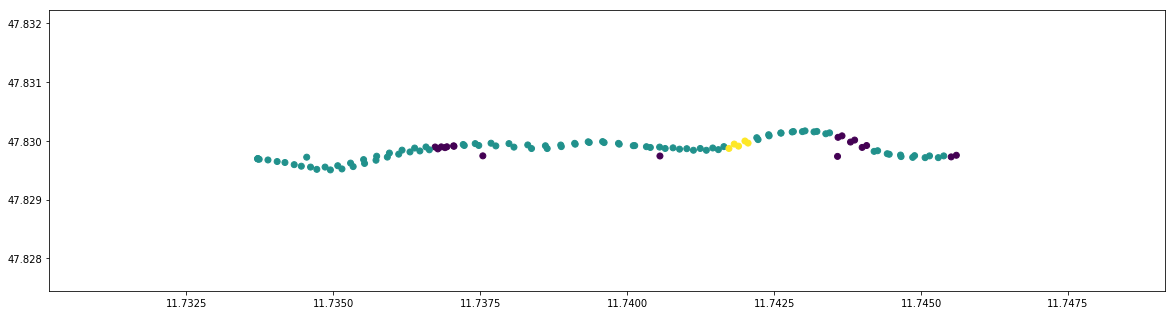

---- dcec ----


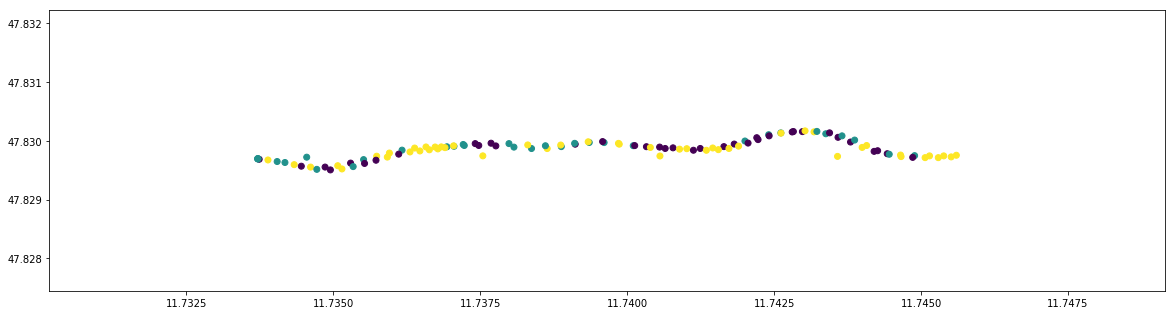

---- fidcec ----


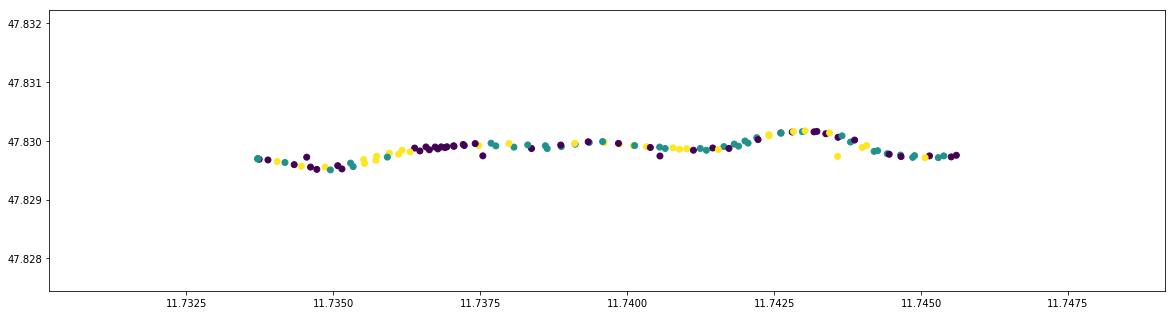

---- classical_raw ----


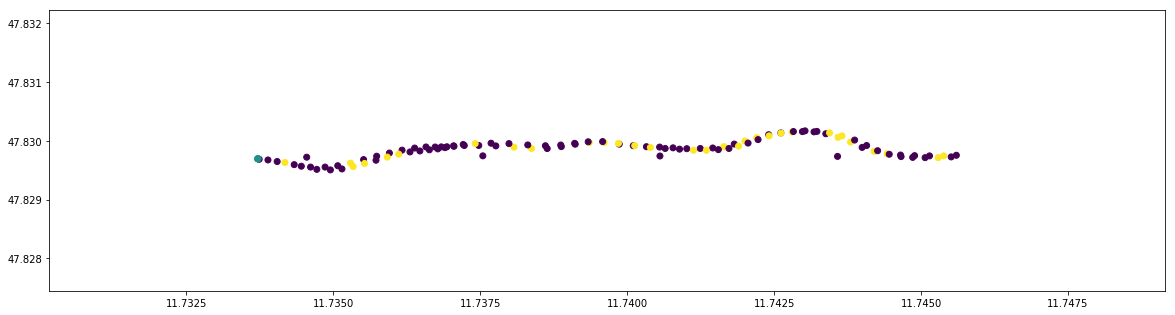

---- classical_raw_fi ----


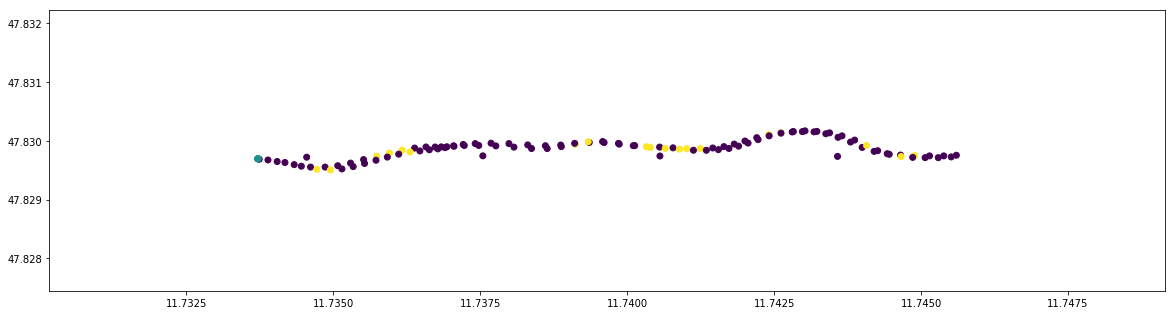

---- classical_features ----


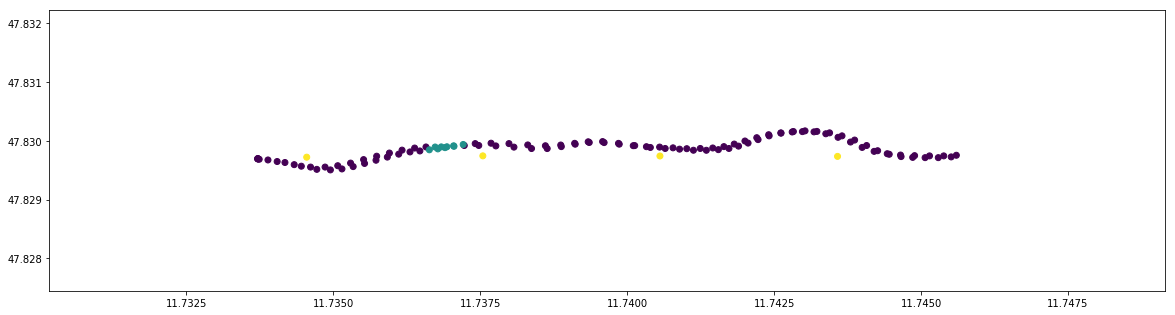

----------------------------------------------------------------
window_length: 300
sub_sample_length: 25
clusters: 4
---- Ground Truth ----


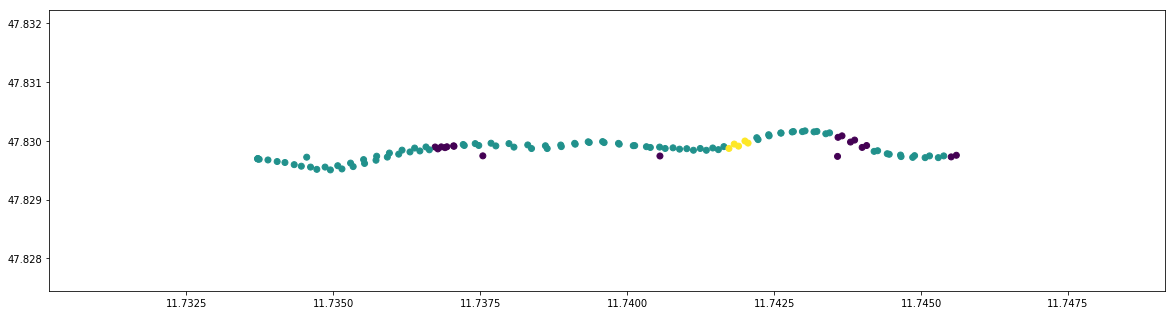

---- dcec ----


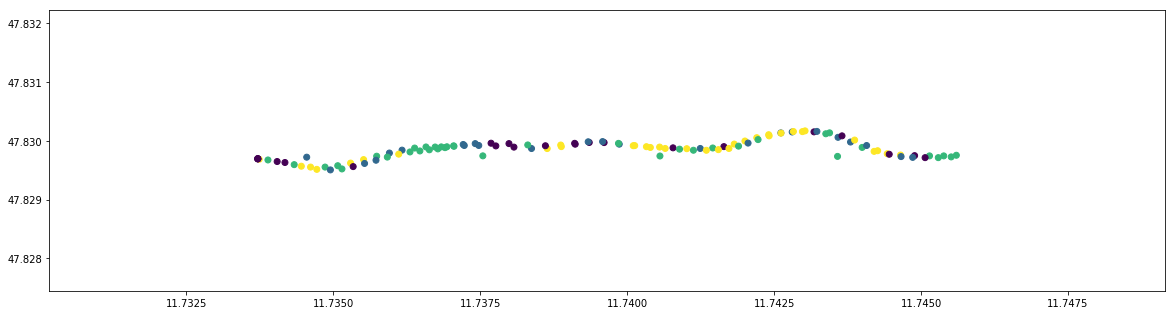

---- fidcec ----


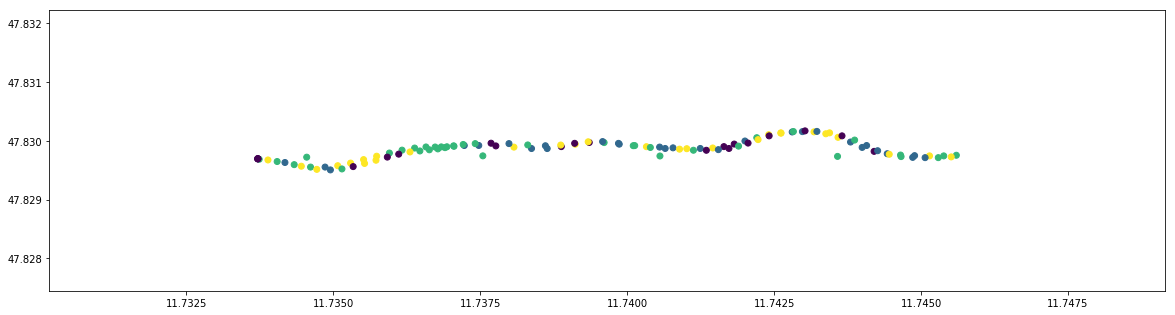

---- classical_raw ----


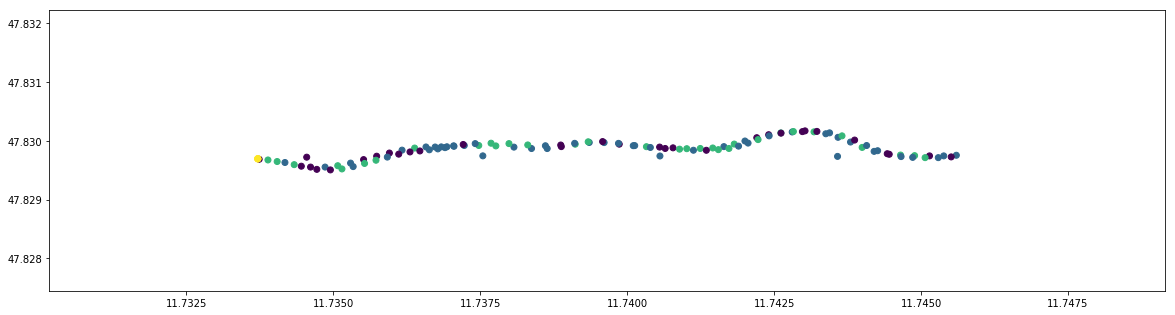

---- classical_raw_fi ----


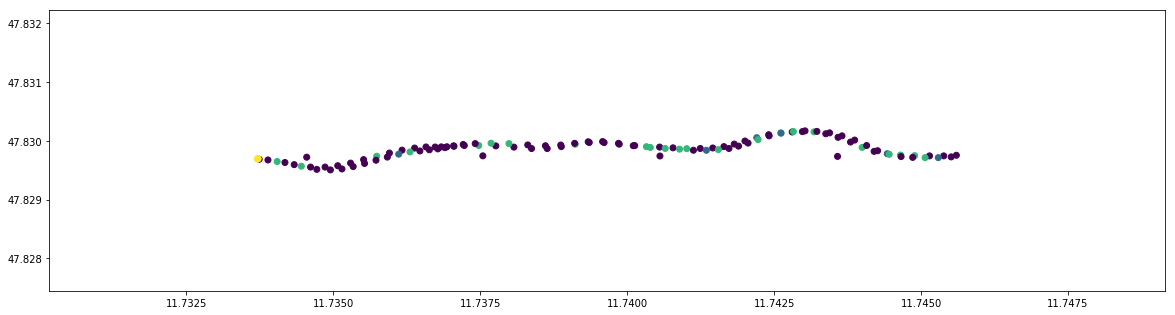

---- classical_features ----


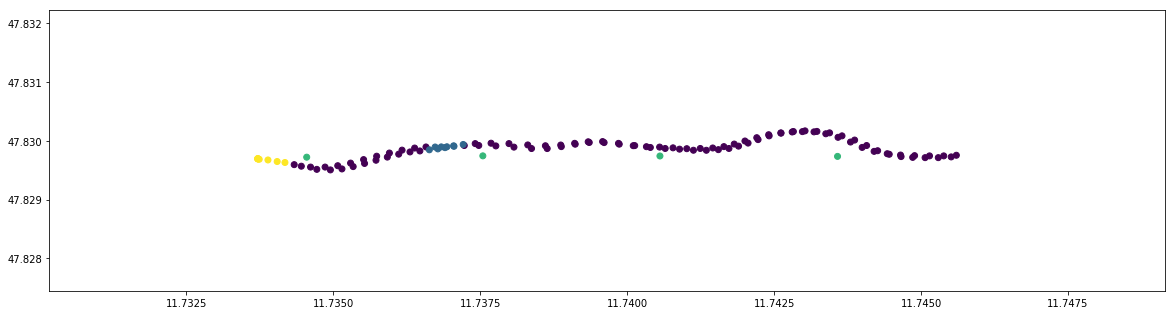

----------------------------------------------------------------
window_length: 300
sub_sample_length: 25
clusters: 9
---- Ground Truth ----


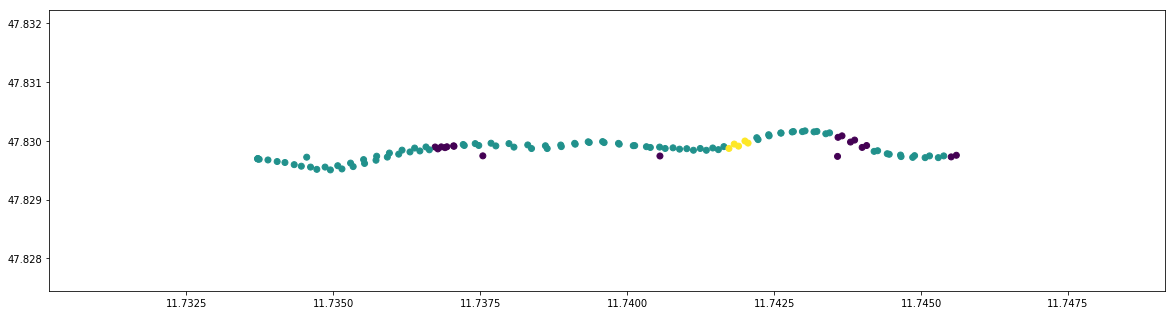

---- dcec ----


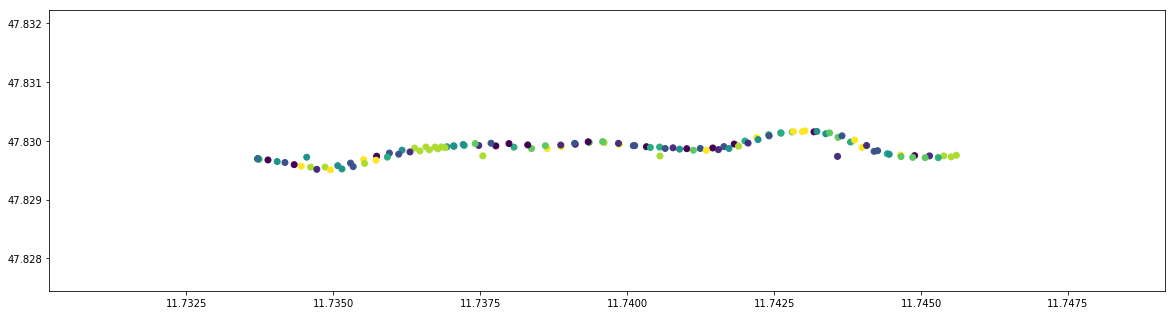

---- fidcec ----


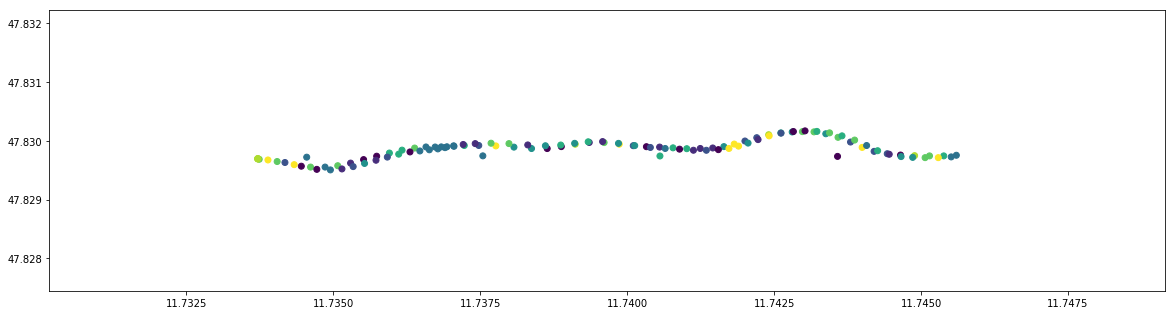

---- classical_raw ----


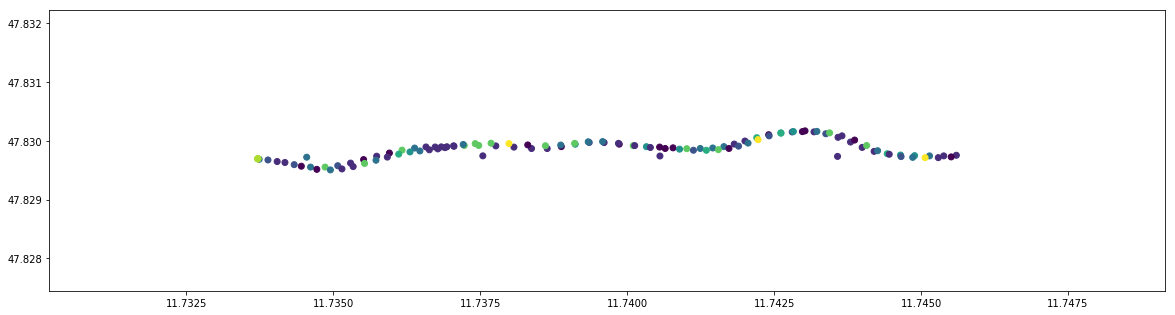

---- classical_raw_fi ----


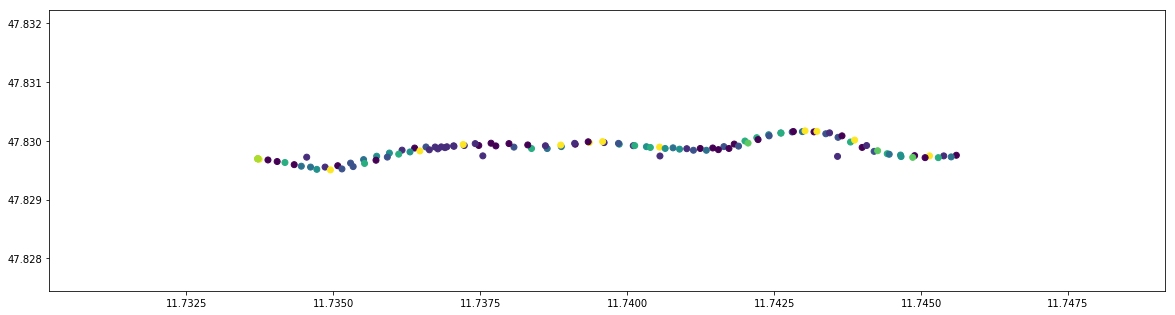

---- classical_features ----


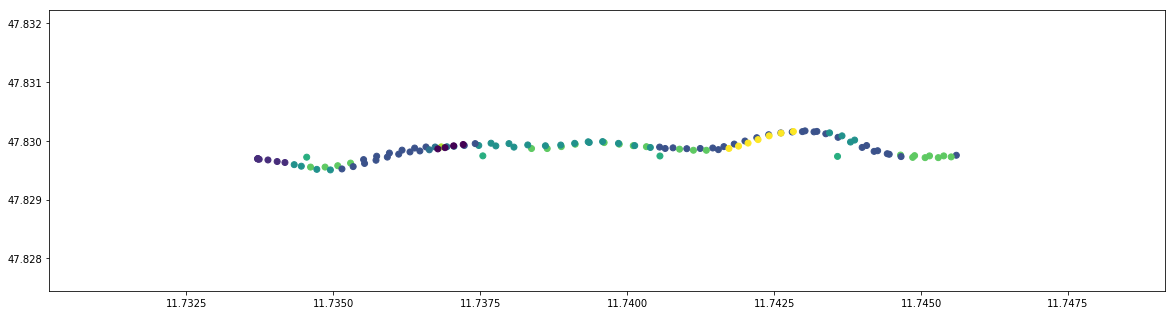

In [202]:
scores = dict()
#eval_prefixes = ['dec', 'fidec', 'dcec', 'fidcec', 'classical_raw', 'classical_raw_fi', 'classical_features']
eval_prefixes = ['dcec', 'fidcec', 'classical_raw', 'classical_raw_fi', 'classical_features']
#score_keys = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score', 'silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score']
score_keys = ['adjusted_rand_score', 'silhouette_score']

for num_clusters in nums_clusters:
    for window_length in window_lengths:
        for sub_sample_length in sub_sample_lengths:
            if sub_sample_length >= window_length:
                continue
                
            if True and (window_length != 300 or sub_sample_length != 25 or not num_clusters in [3,4,9]):
                continue
                
            
            # TODO: Write all cluster variations in one table?

            experiment_prefix = "%s_%s_%s_%s" % (prefix, str(window_length), str(sub_sample_length), str(num_clusters))

            results_complete = None
            for eval_prefix in eval_prefixes:
                filename_scores = "evaluation/%s_%s_score.csv" % (experiment_prefix, eval_prefix)
                results = pd.read_csv(filename_scores).values.T
                results_complete = results if results_complete is None else np.vstack((results_complete, results[-1]))

                for i in range(len(score_keys)):
                    score_prefix = "%s_%s_%s_%s" % (eval_prefix, score_keys[i], str(window_length), str(sub_sample_length))
                    if not score_prefix in scores:
                        scores[score_prefix] = []
                    scores[score_prefix].append(results[-1][i])
                    

            results_complete = results_complete.T
            header = np.hstack(([''], eval_prefixes))
            results_complete = np.insert(results_complete, 0, header, axis=0)
            
            # --------------------- HEADERS ---------------------
            if True:
                print("----------------------------------------------------------------")
                print("window_length:", window_length)
                print("sub_sample_length:", sub_sample_length)
                print("clusters:", num_clusters)
                
            
            # --------------------- TABLES ---------------------
            if False:
                print(pd.DataFrame(results_complete.T), "\n\n")
                
            
            # --------------------- Track PLOTS ---------------------

            if True:

                data_prefix = "%s_%s_%s" % (prefix, str(window_length), str(sub_sample_length))
                filename_features = "data/%s_features.npy" % data_prefix
                filename_labels = "data/%s_labels.npy" % data_prefix
                filename_raw = "data/%s_raw.npy" % data_prefix
                
                feature_file = np.load(filename_features)
                labels = np.load(filename_labels)
                raw_file = np.load(filename_raw)

                print('---- Ground Truth ----')
                geometry = gpd.points_from_xy(feature_file[:, -1], feature_file[:, -2])
                gdf = GeoDataFrame(geometry=geometry)
                gdf.plot(c=labels, figsize=(20, 30))
                plt.show()

                for eval_prefix in eval_prefixes:
                    print('---- %s ----' % eval_prefix)
                    filename_y_pred = "evaluation/%s_%s_y_pred.npy" % (experiment_prefix, eval_prefix)
                    y_pred = np.load(filename_y_pred)
                    gdf = GeoDataFrame(geometry=geometry)
                    gdf.plot(c=y_pred, figsize=(20, 30))
                    plt.show()
                
# --------------------- SCORE PLOTS ---------------------
if False:
    for score_key in score_keys:
        for window_length in window_lengths:
            for sub_sample_length in sub_sample_lengths:
                if sub_sample_length >= window_length:
                    continue

                window_prefix = "%s_%s_%s" % (score_key, str(window_length), str(sub_sample_length))

                figure(1, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
                legend = []
                has_data = False
                for key, score_array in scores.items():
                    if window_prefix in key:
                        has_data = True
                        plt.scatter(x=nums_clusters, y=score_array)
                        legend.append(key)
                
                if has_data:
                    print(window_prefix)
                    plt.legend(legend)
                    plt.show()


##  Exploration

### Plots

In [ ]:
for i in range(len(columns)):
    figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    for data_set in [data_s1_1, data_s1_2, data_s2_1]:
        plt.plot(data_set.T[i])
        #Helpers.print_mean_median_max_min(data_set[i], columns[i])
    #plt.legend(['Trail 1', 'Trail 2'])
    plt.ylabel(columns[i])    

## Auto Tagging and Classification

In [ ]:
col_neureuth = ['SensorAccelerationX_HD', 'SensorAccelerationY_HD', 'SensorAccelerationZ_HD','altitude', 'speed', 'heart_rate', 'SensorHeading', LATITUDE_KEY, LONGITUDE_KEY]
data_neureuth = mtb_data_provider.prepare_raw_data(['neureuth'], col_neureuth, SPEED_THRESHOLD)[0, 0]

In [ ]:
latitudes = data_neureuth[1:, -2]
longitudes = data_neureuth[1:, -1]
top_left, bottom_right = mtb_data_tagger.get_bounding_box_for_recording(latitudes, longitudes, mtb_data_provider, padding=0.0)
response_openstreetmap = mtb_data_tagger.fetch_area_from_openstreetmap(top_left, bottom_right)
response_trailforks = mtb_data_tagger.fetch_area_from_trailforks(top_left, bottom_right)

In [ ]:
openstreetmap_meta = mtb_data_tagger.create_openstreetmap_meta(top_left, bottom_right, response_openstreetmap)
trailforks_meta = mtb_data_tagger.create_trailforks_meta(top_left, bottom_right, response_trailforks)
closest_items = mtb_data_tagger.find_meta_data_for_recording(latitudes, longitudes, openstreetmap_meta, trailforks_meta, mtb_data_provider, distance_threshold=10, fill_empties=5)

In [ ]:
# Plot with data from trailforks and OSM
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

trailforks_difficulties = [0]
osm_difficulties = [0]
physical_ratings = [0]

for closest_item in closest_items:
    difficulty = closest_item['difficulty'] if 'difficulty' in closest_item else 0
    mtb_scale = closest_item['mtb:scale'] if 'mtb:scale' in closest_item else 0
    physical_rating = closest_item['physical_rating'] if 'physical_rating' in closest_item else 0
    trailforks_difficulties.append(difficulty)
    osm_difficulties.append(mtb_scale)
    physical_ratings.append(physical_rating)
    
trailforks_difficulty_results = np.array(trailforks_difficulties).astype(int) 
osm_difficulty_results = np.array(osm_difficulties).astype(int) 
physical_ratings_results = np.array(physical_ratings).astype(int) 
acc_x = data_neureuth[:, 0]
acc_y = data_neureuth[:, 1]
acc_z = data_neureuth[:, 2]
altitude = data_neureuth[:, 3]
speed = data_neureuth[:, 4]
heart_rate = data_neureuth[:, 5]
heading = data_neureuth[:, 6]

norm_acc_x = acc_x / acc_x.max(axis=0)
norm_acc_y = acc_y / acc_y.max(axis=0)
norm_acc_z = acc_z / acc_z.max(axis=0)
norm_altitude = altitude / altitude.max(axis=0)
norm_dif_trailforks = np.divide(trailforks_difficulty_results, 11)
norm_dif_osm = osm_difficulty_results / osm_difficulty_results.max(axis=0)
norm_physical_ratings = np.divide(physical_ratings_results, 4)
norm_altitude = altitude / altitude.max(axis=0)
norm_speed = speed / speed.max(axis=0)
if len(heart_rate):
    norm_heart_rate = heart_rate / heart_rate.max(axis=0)

plt.plot(trailforks_difficulty_results)
plt.plot(osm_difficulty_results)
plt.plot(norm_physical_ratings)
plt.plot(norm_speed)
plt.plot(norm_altitude)
if len(heart_rate):
    plt.plot(norm_heart_rate)
plt.plot(norm_acc_x)
plt.legend(['Difficulty Trailforks', 'Difficulty OSM', 'Physical Ratings', 'Speed', 'Altitude', 'Heart Rate', 'AccX', 'AccY', 'AccZ'])
plt.ylabel('Trail Plot')


In [ ]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(-latitudes, longitudes, c=osm_difficulty_results[:len(latitudes)])

In [ ]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(-latitudes, longitudes, c=trailforks_difficulty_results[:len(latitudes)])

### Classification

In [ ]:
X_neureuth_tmp = data_neureuth
y_neureuth_tmp = osm_difficulty_results

X_neureuth = []
y_neureuth = []

# Ignore Sections without difficulty rating
for i in range(len(y_neureuth_tmp)):
    if y_neureuth_tmp[i] > 0:
        X_neureuth.append(X_neureuth_tmp[i])
        y_neureuth.append(y_neureuth_tmp[i])
        

X_neureuth = np.asarray(X_neureuth)
y_neureuth = np.asarray(y_neureuth)

In [ ]:
classifiers = [
KNeighborsClassifier(3),
#LinearSVC(C=0.025),
DecisionTreeClassifier(max_depth=5, random_state=42),
RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42),
#MLPClassifier(alpha=1, max_iter=20000, random_state=42),
#KMeans(n_clusters=2),
]

names = [
    "Nearest Neighbors", 
#    "Linear SVM", 
    "Decision Tree", 
    "Random Forest", 
#    "Neural Net", 
#   "KMeans",
]

mtb_classifier.run_classification(X_neureuth, y_neureuth, classifiers, names, mtb_data_provider, mtb_visualizer, n_splits=30, clear_outliers=False, print_plots=False)

In [ ]:
X_tmp, y_tmp, _ = mtb_data_provider.create_training_data(data_neureuth, None, window_length=550, step_size=.25, clear_outliers=False, calc_features=True)

altitude_change = X_tmp[:, 8] / X_tmp[:, 8].max(axis=0)
speed_change = X_tmp[:, 9] / X_tmp[:, 9].max(axis=0)
speed_mean = X_tmp[:, 10] / X_tmp[:, 10].max(axis=0)
heading_change = X_tmp[:, 11] / X_tmp[:, 11].max(axis=0)

figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(altitude_change)
#plt.plot(speed_change)
#plt.plot(speed_mean)
#plt.plot(heading_change)
#plt.legend(['altitude change', 'speed change', 'speed_mean', 'heading change', 'heading mean'])

In [ ]:
SPEED_THRESHOLD = .3
LATITUDE_KEY = 'position_lat'
LONGITUDE_KEY = 'position_long'
columns = ['SensorAccelerationX_HD', 'SensorAccelerationY_HD', 'SensorAccelerationZ_HD','altitude', 'speed', 'heart_rate', 'SensorHeading', LATITUDE_KEY, LONGITUDE_KEY]

warngau_files=['neureuth', 'warngaus1_1', 'warngaus1_2', 'warngaus1_3', 'warngaus2_1', 'warngaus2_2']
data_neureuth, data_s1_1, data_s1_2, data_s1_3, data_s2_1, data_s2_2, data_all = mtb_data_provider.prepare_raw_data(warngau_files, columns, SPEED_THRESHOLD)[0]
# TODO: data_all does not exist anymore

### CNN

In [ ]:
mtb_classifier.run_cnn_model(X_neureuth, y_neureuth, mtb_data_provider, mtb_visualizer, n_conv_blocks=3)

### Outlier Detection

In [ ]:
#X_train = data_s2_1[:, :3]
X_train = data_neureuth[:, 0:2]
#X_train = np.array((accX_HD_2,accY_HD_2,accZ_HD_2)).T

for w_length in [50, 100, 150]:
    
    X_train_sliced, _ = mtb_data_provider.slice_into_windows(X_train, window_length=w_length)
    
    X_train_windowed, _ = mtb_data_provider.slice_into_windows(X_train, window_length=w_length, step_size=.25)
    X_train_windowed = X_train_windowed.mean(axis=1)
    X_train_windowed = mtb_data_provider.calculate_features(X_train_windowed)
    
    X_train_sliced = X_train_sliced.mean(axis=1)
    X_train_sliced = mtb_data_provider.calculate_features(X_train_sliced)
    
    clf = KNN(contamination=.2, n_neighbors=30, method='mean', radius=1.0)
    clf.fit(X_train_windowed)

    # get outlier scores
    y_outlier_pred = clf.predict(X_train_sliced)
    y_extended = []

    for y in y_outlier_pred:
        for i in range(w_length):
            y_extended.append(y)

    pca = PCA(n_components=2)
    X = pca.fit_transform(X_train_sliced)
    plt.figure(0)
    figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(X[:, 0], X[:, 1], c=y_outlier_pred)
    plt.ylabel('Window Size: ' + str(w_length))

    plt.figure(1)
    figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    X_train_normed = X_train / X_train.max(axis=0)
    plt.plot(X_train_normed)
    plt.plot(y_extended)
    plt.legend(['X', 'Y', 'Z', 'No Outlier'])#, 'Speed'
    plt.ylabel('Window Size: ' + str(w_length))

### Old dataset

In [ ]:
def prepare_old_data(data_file, label_file):
    acc_data = pd.read_csv(data_file)
    label_annot = pd.read_csv(label_file)
    acc_values = []
    label_values = []
    label_position = 0
    time_dif = int(acc_data.iloc[0]['epoch (ms)'])

    label = label_annot.iloc[label_position]
    label_start = label['start']
    label_end = label['end']
    difficulty = label['difficulty']

    for acc_row in acc_data.iterrows():

        acc_row = acc_row[1]
        acc_abs_timestamp = int(acc_row['epoch (ms)'])
        acc_timestamp = (acc_abs_timestamp - time_dif) / 1000

        if acc_timestamp > label_end and label_position < label_annot.shape[0] -1:
            label_position += 1

        label = label_annot.iloc[label_position]
        label_start = label['start']
        label_end = label['end']
        difficulty = label['difficulty']

    #    if acc_timestamp > label_start and acc_timestamp < label_end:

        if difficulty != 3:
            label_values.append(difficulty)
            acc_values.append(acc_row.values)

    #pd.DataFrame(label_values).to_csv("data/neureuth_labels_1.csv")

    X_n = np.array(acc_values)[:, -3:].astype(float)
    y_n = np.array(label_values).astype(int)
    
    return X_n, y_n

In [ ]:
X_n_1, y_n_1 = prepare_old_data('data/neureuth_acc_1.csv', 'data/neureuth_labels.csv')
X_n_2, y_n_2 = prepare_old_data('data/sachrang_acc_1.csv', 'data/sachrang_labels.csv')

X_n = np.concatenate((X_n_1, X_n_2))
y_n = np.concatenate((y_n_1, y_n_2))

In [ ]:
mtb_classifier.run_classification(X_n, y_n, classifiers, names, mtb_data_provider)